In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('final_project.csv')

In [3]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


In [4]:
df.describe(include='all')

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,...,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,...,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,...,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,...,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,...,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,...,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.305734,...,19.266367,1.453507,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072,1.000000


In [5]:
#df.dtypes

__DD:__ Find all variables that have correlation greater than .75

In [6]:
df_explanatoryVariables = df.drop(['y'], axis=1)
corr_matrix = df_explanatoryVariables.corr().abs()

In [7]:
# Select upper triangle of correlation matrix
correlated = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.5
dropme_correlated = [column for column in correlated.columns if any(correlated[column] > 0.75)]
dropme_correlated

['x6', 'x41']

__DD:__ Findout which variables they are correlated with

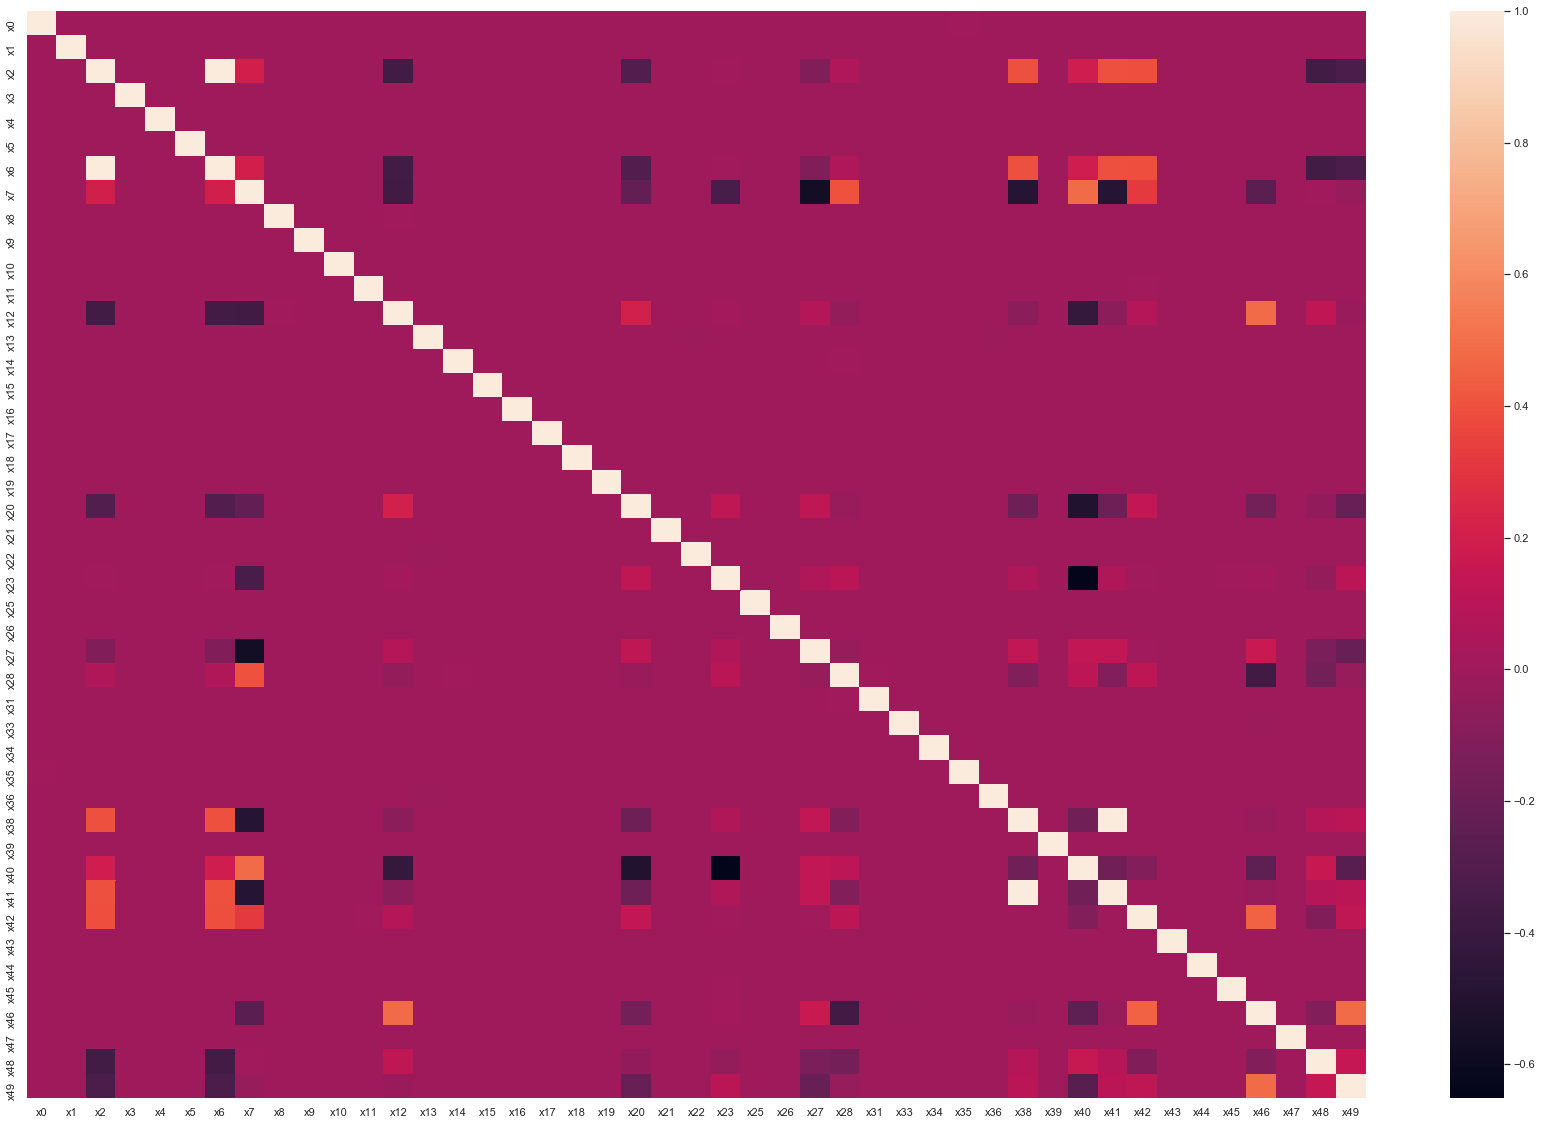

In [8]:
plt.figure(figsize=(30,20))
c= df_explanatoryVariables.corr()
sns.heatmap(c,annot=False)

__DD:__ The following are highly (apparently perfectly) correlated

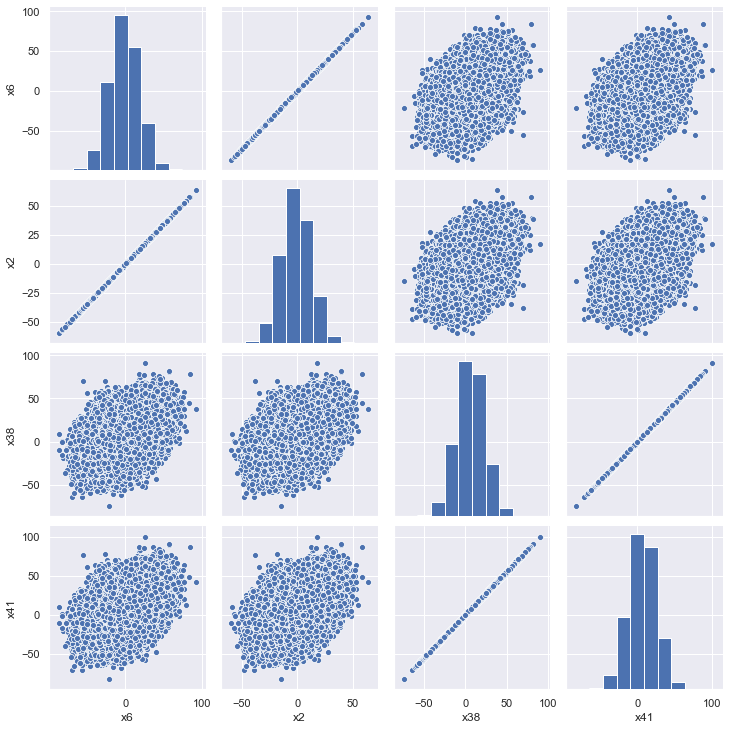

In [9]:
d=['x6', 'x2','x38','x41']
sns.pairplot(df_explanatoryVariables[d])

__DD:__ Drop x6 and x41

In [10]:
df_explanatoryVariables.drop(df_explanatoryVariables[dropme_correlated], axis=1)

,x0,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x39,x40,x42,x43,x44,x45,x46,x47,x48,x49
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,-14.789997,-1.040673,-4.204950,6.187465,...,-5.186148,-10.612200,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,-6.725709,0.896421,0.330165,-11.708859,...,-5.150012,2.147427,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,11.060572,5.325880,-2.632984,1.572647,...,8.728585,-0.863137,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-18.913592,-0.337041,-5.568076,-2.000255,...,-6.385060,12.084421,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,27.532281,1.199715,-4.309105,6.667530,...,1.133798,30.004727,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-0.487024,-4.270269,0.417395,-1.992423,1.757552,-1.167819,41.084463,-1.923188,-2.374213,-0.767600,...,2.475853,-5.032652,8.096802,-0.875131,-1.413787,-0.363968,15.339392,4.364205,-3.831489,28.389858
159996,0.825477,4.804368,22.161535,11.371303,1.715901,6.990759,-12.278038,-3.861086,6.715126,-6.476405,...,-7.420619,-8.472736,0.841446,-0.682177,-5.047677,-0.017898,0.780130,6.387266,-1.374742,-1.623952
159997,-0.802489,5.362696,7.243419,-7.496074,2.295250,-2.756067,42.515821,1.420984,6.788916,-0.132832,...,-8.381138,22.669070,-0.144098,0.738298,7.241041,0.215347,-12.155249,3.265263,1.230963,3.335471
159998,0.339237,7.609895,5.368414,-2.825481,4.046102,15.322603,-10.233054,2.609986,4.251127,-7.484309,...,-0.590201,-32.356360,-0.601145,-3.443112,0.549931,0.206728,5.081980,1.701462,-0.279619,-1.986424


In [12]:
#sns.boxplot(x=df['x41'])

qtw final

Required
Deliverable:
I want you to minimize my dollar cost on an UNKNOWN dataset
That means one you can never see.  Ever.
Each False Positive costs me $10
Each False Negative costs me $500
True Positives and True Negatives cost me $0

Problem:
Cost-sensitive learning 

cost function:
 Total Cost = 10 * Count of FP + 500 * Count of FN

Goal: minimize False Negative or Type-II error


Precision = TruePositives / (TruePositives + FalsePositives)

Recall = TruePositives / (TruePositives + FalseNegatives)

The intuition for recall is that it is not concerned with false positives and it minimizes false negatives. 

Precision is a metric that calculates the percentage of correct predictions for the positive class. Recall calculates the percentage of correct predictions for the positive class out of all positive predictions that could be made. Maximizing precision will minimize the false-positive errors, whereas maximizing recall will minimize the false-negative errors.

Methods
Metric Choice


Fbeta 

Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)

When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose. For example, with F1 score we care equally about recall and precision with F2 score, recall is twice as important to us.

F50

How to compute:
from sklearn.metrics import fbeta_score
y_pred_class = y_pred_pos > threshold
fbeta_score(y_true, y_pred_class, beta)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

calculate the f2-measure
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# perfect precision, 50% recall
y_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)
f = fbeta_score(y_true, y_pred, beta=2.0)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

eda

check y distribution

pca and see

xgb f beta
if have time rf

ref
https://machinelearningmastery.com/fbeta-measure-for-machine-learning/
https://stackoverflow.com/questions/41060719/using-evaluation-functions-with-parameter-in-xgboost-f-beta